In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Union


class Encoder(nn.Module):
    """Encoder component of the VAE-LSTM hybrid model"""

    def __init__(self, input_size: int, hidden_size: int, latent_dim: int, num_layers: int = 1):
        """
        Args:
            input_size: Number of input features
            hidden_size: Size of hidden layer in LSTM
            latent_dim: Dimension of latent space
            num_layers: Number of LSTM layers
        """
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Mean and log variance for VAE
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass through the encoder

        Args:
            x: Input time series data of shape (batch_size, seq_len, input_size)

        Returns:
            mu: Mean of the latent space
            logvar: Log variance of the latent space
            hidden: Last hidden state of LSTM
        """
        # Pass through LSTM
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use the last hidden state
        hidden_last = hidden[-1]  # Shape: (batch_size, hidden_size)

        # Project to latent space
        mu = self.fc_mu(hidden_last)
        logvar = self.fc_logvar(hidden_last)

        return mu, logvar, hidden_last


class Decoder(nn.Module):
    """Decoder component of the VAE-LSTM hybrid model"""

    def __init__(self, latent_dim: int, hidden_size: int, output_size: int, seq_length: int, num_layers: int = 1):
        """
        Args:
            latent_dim: Dimension of latent space
            hidden_size: Size of hidden layer in LSTM
            output_size: Number of output features
            seq_length: Length of output sequence
            num_layers: Number of LSTM layers
        """
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_length = seq_length
        self.num_layers = num_layers

        # Project latent vector to initial hidden state
        self.fc_hidden = nn.Linear(latent_dim, hidden_size)
        self.fc_cell = nn.Linear(latent_dim, hidden_size)

        # Input projection
        self.fc_input = nn.Linear(latent_dim, output_size)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Output projection
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the decoder

        Args:
            z: Latent vector of shape (batch_size, latent_dim)

        Returns:
            Reconstructed time series of shape (batch_size, seq_length, output_size)
        """
        batch_size = z.size(0)

        # Initialize hidden and cell states
        h0 = self.fc_hidden(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = self.fc_cell(z).unsqueeze(0).repeat(self.num_layers, 1, 1)

        # Create initial input sequence (batch_size, seq_length, output_size)
        init_input = self.fc_input(z).unsqueeze(1).repeat(1, self.seq_length, 1)

        # Pass through LSTM
        lstm_out, _ = self.lstm(init_input, (h0, c0))

        # Apply output projection
        output = self.fc_output(lstm_out)

        return output


class VAE_LSTM(nn.Module):
    """VAE-LSTM hybrid model for time series anomaly detection"""

    def __init__(self, input_size: int, hidden_size: int, latent_dim: int, seq_length: int, num_layers: int = 1):
        """
        Args:
            input_size: Number of input features
            hidden_size: Size of hidden layer in LSTM
            latent_dim: Dimension of latent space
            seq_length: Length of input/output sequence
            num_layers: Number of LSTM layers
        """
        super(VAE_LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.seq_length = seq_length
        self.num_layers = num_layers

        # Encoder and decoder components
        self.encoder = Encoder(input_size, hidden_size, latent_dim, num_layers)
        self.decoder = Decoder(latent_dim, hidden_size, input_size, seq_length, num_layers)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick for VAE

        Args:
            mu: Mean of the latent distribution
            logvar: Log variance of the latent distribution

        Returns:
            Sampled latent vector
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass through the VAE-LSTM

        Args:
            x: Input time series data of shape (batch_size, seq_length, input_size)

        Returns:
            recon_x: Reconstructed time series
            mu: Mean of the latent space
            logvar: Log variance of the latent space
        """
        # Encode
        mu, logvar, _ = self.encoder(x)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

    def loss_function(self, recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, dict]:
        """
        Compute VAE loss

        Args:
            recon_x: Reconstructed time series
            x: Original time series
            mu: Mean of the latent space
            logvar: Log variance of the latent space

        Returns:
            loss: Total loss
            loss_dict: Dictionary with individual loss components
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')

        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        total_loss = recon_loss + kl_loss

        # Return losses as dictionary for logging
        loss_dict = {
            'total_loss': total_loss.item(),
            'recon_loss': recon_loss.item(),
            'kl_loss': kl_loss.item()
        }

        return total_loss, loss_dict

    def predict(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate reconstruction and compute reconstruction error

        Args:
            x: Input time series data

        Returns:
            recon_x: Reconstructed time series
            recon_error: Reconstruction error (MSE) for each sample
        """
        # Forward pass through the model
        recon_x, _, _ = self.forward(x)

        # Compute reconstruction error (MSE) for each sample and timestep
        recon_error = torch.mean((x - recon_x) ** 2, dim=(1, 2))

        return recon_x, recon_error


class TimeSeriesDataset:
    """Helper class to prepare time series data for the VAE-LSTM model"""

    def __init__(self, data: Union[np.ndarray, pd.DataFrame], seq_length: int, train_split: float = 0.8):
        """
        Args:
            data: Time series data as numpy array or pandas DataFrame
            seq_length: Length of sliding window for creating sequences
            train_split: Ratio of data to use for training (0-1)
        """
        self.data = data.values if isinstance(data, pd.DataFrame) else data
        self.seq_length = seq_length
        self.train_split = train_split
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.n_features = self.data.shape[1] if len(self.data.shape) > 1 else 1

        # Prepare data
        self._prepare_data()

    def _prepare_data(self):
        """Prepare and split the data into training and test sets"""
        # Ensure data is 2D
        if len(self.data.shape) == 1:
            self.data = self.data.reshape(-1, 1)

        # Scale data
        self.data_scaled = self.scaler.fit_transform(self.data)

        # Create sequences
        self.sequences = self._create_sequences(self.data_scaled)

        # Split into train and test
        train_size = int(len(self.sequences) * self.train_split)
        self.train_data = self.sequences[:train_size]
        self.test_data = self.sequences[train_size:]

        # Convert to torch tensors
        self.train_tensor = torch.FloatTensor(self.train_data)
        self.test_tensor = torch.FloatTensor(self.test_data)

    def _create_sequences(self, data: np.ndarray) -> np.ndarray:
        """
        Create sequences using sliding window

        Args:
            data: Scaled time series data

        Returns:
            Sequences of shape (n_sequences, seq_length, n_features)
        """
        sequences = []
        for i in range(len(data) - self.seq_length + 1):
            seq = data[i:i+self.seq_length]
            sequences.append(seq)
        return np.array(sequences)

    def get_train_dataloader(self, batch_size: int) -> DataLoader:
        """Get DataLoader for training data"""
        dataset = TensorDataset(self.train_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def get_test_dataloader(self, batch_size: int) -> DataLoader:
        """Get DataLoader for test data"""
        dataset = TensorDataset(self.test_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=False)

    def inverse_transform(self, data: np.ndarray) -> np.ndarray:
        """Transform data back to original scale"""
        return self.scaler.inverse_transform(data)


def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader,
                epochs: int, learning_rate: float = 1e-3) -> Dict[str, List[float]]:
    """
    Train the VAE-LSTM model

    Args:
        model: VAE-LSTM model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer

    Returns:
        Dictionary with training and validation loss history
    """
    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize loss history
    history = {
        'train_loss': [],
        'test_loss': [],
        'recon_loss': [],
        'kl_loss': []
    }

    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        recon_loss_sum = 0
        kl_loss_sum = 0

        for batch_idx, (data,) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = model(data)
            loss, loss_dict = model.loss_function(recon_batch, data, mu, logvar)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate losses
            train_loss += loss.item()
            recon_loss_sum += loss_dict['recon_loss']
            kl_loss_sum += loss_dict['kl_loss']

        # Average losses
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_recon_loss = recon_loss_sum / len(train_loader.dataset)
        avg_kl_loss = kl_loss_sum / len(train_loader.dataset)

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['kl_loss'].append(avg_kl_loss)

        # Validation
        model.eval()
        test_loss = 0

        with torch.no_grad():
            for batch_idx, (data,) in enumerate(test_loader):
                recon_batch, mu, logvar = model(data)
                loss, _ = model.loss_function(recon_batch, data, mu, logvar)
                test_loss += loss.item()

        # Average test loss
        avg_test_loss = test_loss / len(test_loader.dataset)
        history['test_loss'].append(avg_test_loss)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {avg_train_loss:.6f}, '
              f'Recon Loss: {avg_recon_loss:.6f}, '
              f'KL Loss: {avg_kl_loss:.6f}, '
              f'Test Loss: {avg_test_loss:.6f}')

    return history


def find_threshold(model: nn.Module, loader: DataLoader, percentile: float = 95) -> float:
    """
    Find anomaly threshold based on reconstruction errors

    Args:
        model: Trained VAE-LSTM model
        loader: DataLoader for validation/test data
        percentile: Percentile to use for threshold (default: 95)

    Returns:
        Threshold value
    """
    model.eval()
    recon_errors = []

    with torch.no_grad():
        for (data,) in loader:
            _, recon_error = model.predict(data)
            recon_errors.append(recon_error.numpy())

    # Flatten errors
    all_errors = np.concatenate(recon_errors)

    # Calculate threshold based on percentile
    threshold = np.percentile(all_errors, percentile)
    return threshold


def detect_anomalies(model: nn.Module, data: torch.Tensor, threshold: float) -> np.ndarray:
    """
    Detect anomalies in time series data

    Args:
        model: Trained VAE-LSTM model
        data: Input time series data as torch tensor
        threshold: Anomaly threshold

    Returns:
        Boolean array indicating anomalies
    """
    model.eval()
    with torch.no_grad():
        _, recon_error = model.predict(data)

    # Convert to numpy for easier manipulation
    recon_error_np = recon_error.numpy()

    # Flag anomalies
    anomalies = recon_error_np > threshold

    return anomalies


def plot_results(original: np.ndarray, reconstructed: np.ndarray, anomalies: np.ndarray,
                window_size: int, start_idx: int = 0, end_idx: int = None):
    """
    Plot original vs reconstructed time series with anomalies highlighted

    Args:
        original: Original time series data
        reconstructed: Reconstructed time series data
        anomalies: Boolean array indicating anomalies
        window_size: Size of sliding window used for sequences
        start_idx: Start index for plotting
        end_idx: End index for plotting
    """
    if end_idx is None:
        end_idx = len(original)

    # Ensure indices are valid
    start_idx = max(0, start_idx)
    end_idx = min(len(original), end_idx)

    # Create time index
    time_idx = np.arange(start_idx, end_idx)

    # Find anomaly indices
    anomaly_indices = np.where(anomalies)[0]
    anomaly_indices = anomaly_indices[(anomaly_indices >= start_idx) & (anomaly_indices < end_idx)]

    # Plot
    plt.figure(figsize=(15, 8))

    # Original data
    plt.plot(time_idx, original[start_idx:end_idx], 'b-', label='Original')

    # Reconstructed data
    plt.plot(time_idx, reconstructed[start_idx:end_idx], 'g-', label='Reconstructed')

    # Highlight anomalies
    for idx in anomaly_indices:
        # Highlight window around anomaly
        window_start = max(start_idx, idx - window_size//2)
        window_end = min(end_idx, idx + window_size//2)
        plt.axvspan(window_start, window_end, color='red', alpha=0.3)

        # Mark anomaly point
        plt.plot(idx, original[idx], 'ro', markersize=8)

    plt.title('Time Series Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


class PrometheusDataProcessor:
    """Helper class to process Prometheus metrics for the VAE-LSTM model"""

    def __init__(self, seq_length: int):
        """
        Args:
            seq_length: Length of sliding window for creating sequences
        """
        self.seq_length = seq_length
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def prepare_data(self, df: pd.DataFrame, feature_columns: List[str]) -> Tuple[torch.Tensor, dict]:
        """
        Prepare Prometheus data for inference

        Args:
            df: DataFrame with Prometheus metrics
            feature_columns: List of column names to use as features

        Returns:
            Tensor of input sequences and scaler for inverse transformation
        """
        # Extract features
        data = df[feature_columns].values

        # Scale data
        data_scaled = self.scaler.fit_transform(data)

        # Create sequences
        sequences = self._create_sequences(data_scaled)

        # Convert to torch tensor
        tensor_data = torch.FloatTensor(sequences)

        return tensor_data, {'scaler': self.scaler}

    def _create_sequences(self, data: np.ndarray) -> np.ndarray:
        """
        Create sequences using sliding window

        Args:
            data: Scaled time series data

        Returns:
            Sequences of shape (n_sequences, seq_length, n_features)
        """
        sequences = []
        for i in range(len(data) - self.seq_length + 1):
            seq = data[i:i+self.seq_length]
            sequences.append(seq)
        return np.array(sequences)

    def inverse_transform(self, data: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
        """Transform data back to original scale"""
        return scaler.inverse_transform(data)


def train_on_cpu_ram_dataset(dataset_path: str, seq_length: int = 100, batch_size: int = 32,
                            hidden_size: int = 64, latent_dim: int = 16, epochs: int = 50):
    """
    Train VAE-LSTM model on a CPU/RAM usage dataset

    Args:
        dataset_path: Path to dataset CSV file
        seq_length: Length of sliding window for creating sequences
        batch_size: Batch size for training
        hidden_size: Size of hidden layer in LSTM
        latent_dim: Dimension of latent space
        epochs: Number of training epochs

    Returns:
        Trained model and dataset
    """
    # Load data
    df = pd.read_csv(dataset_path)

    # Create dataset
    dataset = TimeSeriesDataset(df, seq_length=seq_length)

    # Get input size from dataset
    input_size = dataset.n_features

    # Create model
    model = VAE_LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        latent_dim=latent_dim,
        seq_length=seq_length
    )

    # Get dataloaders
    train_loader = dataset.get_train_dataloader(batch_size=batch_size)
    test_loader = dataset.get_test_dataloader(batch_size=batch_size)

    # Train model
    history = train_model(model, train_loader, test_loader, epochs=epochs)

    # Find threshold
    threshold = find_threshold(model, test_loader)

    return model, dataset, threshold, history


def infer_on_prometheus_data(model: nn.Module, prometheus_df: pd.DataFrame,
                           feature_columns: List[str], seq_length: int, threshold: float):
    """
    Perform anomaly detection on Prometheus data

    Args:
        model: Trained VAE-LSTM model
        prometheus_df: DataFrame with Prometheus metrics
        feature_columns: List of column names to use as features
        seq_length: Length of sliding window for creating sequences
        threshold: Anomaly threshold

    Returns:
        DataFrame with original data and anomaly flags
    """
    # Prepare data processor
    processor = PrometheusDataProcessor(seq_length=seq_length)

    # Prepare data for inference
    tensor_data, meta = processor.prepare_data(prometheus_df, feature_columns)

    # Run inference
    model.eval()
    with torch.no_grad():
        recon_batch, mu, logvar = model(tensor_data)
        _, recon_error = model.predict(tensor_data)

    # Convert to numpy
    recon_error_np = recon_error.numpy()

    # Detect anomalies
    anomalies = recon_error_np > threshold

    # Convert tensor to numpy
    recon_np = recon_batch.numpy()

    # Reshape for inverse transformation
    batch_size, seq_len, n_features = recon_np.shape
    recon_flat = recon_np.reshape(-1, n_features)

    # Inverse transform
    recon_orig = processor.inverse_transform(recon_flat, meta['scaler'])

    # Reshape back
    recon_orig = recon_orig.reshape(batch_size, seq_len, n_features)

    # Create result DataFrame
    # Note: Each sequence corresponds to a window of data
    # To map back to original time points, we need to consider the overlap

    # We'll take the middle point of each sequence for simplicity
    middle_idx = seq_length // 2
    result_indices = range(middle_idx, len(prometheus_df) - middle_idx)

    # Extract middle points from sequences
    result_data = {
        'timestamp': prometheus_df.index[result_indices],
    }

    # Add original features
    for i, col in enumerate(feature_columns):
        result_data[col] = prometheus_df[col].values[result_indices]
        result_data[f'recon_{col}'] = recon_orig[:, middle_idx, i]

    # Add anomaly flag
    result_data['anomaly'] = anomalies
    result_data['recon_error'] = recon_error_np

    # Create DataFrame
    result_df = pd.DataFrame(result_data)

    return result_df


def save_model(model: nn.Module, path: str):
    """Save model weights to disk"""
    torch.save(model.state_dict(), path)


def load_model(path: str, input_size: int, hidden_size: int, latent_dim: int, seq_length: int):
    """Load model weights from disk"""
    model = VAE_LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        latent_dim=latent_dim,
        seq_length=seq_length
    )
    model.load_state_dict(torch.load(path))
    return model



In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Training script for VAE-LSTM Anomaly Detection on CPU/RAM usage data
"""

import argparse
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Union

# Import the VAE-LSTM model (assuming it's in vae_lstm_model.py)
# from vae_lstm_model import VAE_LSTM, TimeSeriesDataset, train_model, find_threshold, detect_anomalies, plot_results


def load_dataset(dataset_name: str) -> pd.DataFrame:
    """
    Load a dataset based on its name

    Args:
        dataset_name: Name of the dataset to load

    Returns:
        DataFrame with loaded data
    """
    # Popular datasets for CPU/RAM usage anomaly detection
    datasets = {
        'nasa': 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv',
        'aws': 'https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv',
        'yahoo': 'https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv',
        'art_daily': 'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv',
        'art_flatline': 'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_flatmiddle.csv'
    }

    if dataset_name in datasets:
        url = datasets[dataset_name]
        print(f"Loading dataset '{dataset_name}' from {url}")
        df = pd.read_csv(url)

        # Basic data cleaning and preparation

        # Handle timestamp column
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.set_index('timestamp', inplace=True)

        # Different datasets have different value column names
        value_columns = [col for col in df.columns if col.lower() in ['value', 'cpu', 'usage', 'utilization']]
        if value_columns:
            # If the dataset has multiple value columns, keep all of them
            # Otherwise, rename the single value column to 'value'
            if len(value_columns) == 1:
                df.rename(columns={value_columns[0]: 'value'}, inplace=True)
        else:
            print("Warning: Could not identify value column. Using the first numeric column.")
            numeric_cols = df.select_dtypes(include=['number']).columns
            if len(numeric_cols) > 0:
                df.rename(columns={numeric_cols[0]: 'value'}, inplace=True)
            else:
                raise ValueError("No numeric columns found in the dataset.")

        return df
    elif dataset_name.endswith('.csv'):
        # Load from local CSV file
        if os.path.exists(dataset_name):
            print(f"Loading dataset from local file: {dataset_name}")
            df = pd.read_csv(dataset_name)
            return df
        else:
            raise FileNotFoundError(f"File {dataset_name} not found.")
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}. Available datasets: {list(datasets.keys())}")


def train_and_evaluate(df: pd.DataFrame, args: argparse.Namespace) -> Tuple[VAE_LSTM, float, Dict]:
    """
    Train and evaluate the VAE-LSTM model on the given dataset

    Args:
        df: Input DataFrame with time series data
        args: Command line arguments

    Returns:
        Trained model, anomaly threshold, and training history
    """
    # Extract features (use all numeric columns)
    feature_cols = df.select_dtypes(include=['number']).columns.tolist()
    print(f"Using features: {feature_cols}")

    # Create dataset
    dataset = TimeSeriesDataset(
        df[feature_cols],
        seq_length=args.seq_length,
        train_split=args.train_split
    )

    # Get input size from dataset
    input_size = dataset.n_features
    print(f"Input size: {input_size}")

    # Create model
    model = VAE_LSTM(
        input_size=input_size,
        hidden_size=args.hidden_size,
        latent_dim=args.latent_dim,
        seq_length=args.seq_length,
        num_layers=args.num_layers
    )

    print(f"Model created with parameters:")
    print(f"  - Input size: {input_size}")
    print(f"  - Hidden size: {args.hidden_size}")
    print(f"  - Latent dim: {args.latent_dim}")
    print(f"  - Sequence length: {args.seq_length}")
    print(f"  - Number of LSTM layers: {args.num_layers}")

    # Get dataloaders
    train_loader = dataset.get_train_dataloader(batch_size=args.batch_size)
    test_loader = dataset.get_test_dataloader(batch_size=args.batch_size)

    # Train model
    print("\nStarting training...")
    history = train_model(model, train_loader, test_loader, epochs=args.epochs, learning_rate=args.learning_rate)

    # Find threshold for anomaly detection
    print(f"\nFinding anomaly threshold at {args.percentile}th percentile...")
    threshold = find_threshold(model, test_loader, percentile=args.percentile)
    print(f"Anomaly threshold: {threshold:.6f}")

    # Evaluate on test data
    print("\nEvaluating on test data...")
    model.eval()
    test_recons = []
    test_errors = []

    with torch.no_grad():
        for batch_idx, (data,) in enumerate(test_loader):
            recon_batch, _, _ = model(data)
            _, recon_error = model.predict(data)

            test_recons.append(recon_batch.numpy())
            test_errors.append(recon_error.numpy())

    # Concatenate results
    test_recons = np.concatenate(test_recons, axis=0)
    test_errors = np.concatenate(test_errors, axis=0)

    # Detect anomalies
    anomalies = test_errors > threshold
    print(f"Detected {np.sum(anomalies)} anomalies in test data.")

    # Plot results if requested
    if args.plot:
        print("\nPlotting results...")

        # For simplicity, just plot the first feature
        feature_idx = 0
        feature_name = feature_cols[feature_idx]

        # Original test data
        original_test = dataset.test_tensor.numpy()

        # Reshape for easier plotting
        original_flat = original_test[:, :, feature_idx].flatten()
        recon_flat = test_recons[:, :, feature_idx].flatten()

        # Create time index
        time_idx = np.arange(len(original_flat))

        # Expand anomalies to match the sequence length
        expanded_anomalies = np.zeros_like(original_flat, dtype=bool)
        for i, is_anomaly in enumerate(anomalies):
            if is_anomaly:
                start_idx = i * args.seq_length
                end_idx = start_idx + args.seq_length
                expanded_anomalies[start_idx:end_idx] = True

        # Plot
        plt.figure(figsize=(15, 8))

        # Original data
        plt.plot(time_idx, original_flat, 'b-', label='Original')

        # Reconstructed data
        plt.plot(time_idx, recon_flat, 'g-', label='Reconstructed')

        # Highlight anomalies
        anomaly_idx = np.where(expanded_anomalies)[0]
        if len(anomaly_idx) > 0:
            plt.plot(time_idx[anomaly_idx], original_flat[anomaly_idx], 'ro', markersize=4, label='Anomalies')

        plt.title(f'VAE-LSTM Anomaly Detection - {feature_name}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save plot if output directory is provided
        if args.output_dir:
            os.makedirs(args.output_dir, exist_ok=True)
            plt.savefig(os.path.join(args.output_dir, 'test_results.png'))

        plt.show()

    return model, threshold, history


def save_outputs(model: VAE_LSTM, threshold: float, history: Dict, args: argparse.Namespace):
    """
    Save model, threshold, and training metrics

    Args:
        model: Trained VAE-LSTM model
        threshold: Anomaly detection threshold
        history: Dictionary with training history
        args: Command line arguments
    """
    if args.output_dir:
        os.makedirs(args.output_dir, exist_ok=True)

        # Save model
        model_path = os.path.join(args.output_dir, 'vae_lstm_model.pth')
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

        # Save threshold
        threshold_path = os.path.join(args.output_dir, 'threshold.txt')
        with open(threshold_path, 'w') as f:
            f.write(str(threshold))
        print(f"Threshold saved to {threshold_path}")

        # Save model config
        config_path = os.path.join(args.output_dir, 'model_config.txt')
        with open(config_path, 'w') as f:
            f.write(f"input_size: {model.input_size}\n")
            f.write(f"hidden_size: {model.hidden_size}\n")
            f.write(f"latent_dim: {model.latent_dim}\n")
            f.write(f"seq_length: {model.seq_length}\n")
            f.write(f"num_layers: {model.num_layers}\n")
        print(f"Model config saved to {config_path}")

        # Save training history
        history_path = os.path.join(args.output_dir, 'training_history.csv')
        history_df = pd.DataFrame(history)
        history_df.to_csv(history_path, index=False)
        print(f"Training history saved to {history_path}")

        # Plot training history
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train')
        plt.plot(history['test_loss'], label='Test')
        plt.title('Total Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history['recon_loss'], label='Reconstruction')
        plt.plot(history['kl_loss'], label='KL Divergence')
        plt.title('Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        history_plot_path = os.path.join(args.output_dir, 'training_history.png')
        plt.savefig(history_plot_path)
        print(f"Training history plot saved to {history_plot_path}")


def main_train_arg():
    """Main entry point"""
    parser = argparse.ArgumentParser(description='Train VAE-LSTM model for time series anomaly detection')

    # Dataset parameters
    parser.add_argument('--dataset', type=str, required=True,
                      help='Dataset to use. Can be one of the predefined datasets (nasa, aws, yahoo, art_daily, art_flatline) or a path to a CSV file')
    parser.add_argument('--seq_length', type=int, default=100,
                      help='Length of input sequences')
    parser.add_argument('--train_split', type=float, default=0.8,
                      help='Ratio of data to use for training (0-1)')

    # Model parameters
    parser.add_argument('--hidden_size', type=int, default=64,
                      help='Size of hidden layer in LSTM')
    parser.add_argument('--latent_dim', type=int, default=16,
                      help='Dimension of latent space')
    parser.add_argument('--num_layers', type=int, default=1,
                      help='Number of LSTM layers')

    # Training parameters
    parser.add_argument('--batch_size', type=int, default=32,
                      help='Batch size for training')
    parser.add_argument('--epochs', type=int, default=50,
                      help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=1e-3,
                      help='Learning rate for optimizer')

    # Anomaly detection parameters
    parser.add_argument('--percentile', type=float, default=95,
                      help='Percentile to use for anomaly threshold')

    # Output parameters
    parser.add_argument('--output_dir', type=str, default='outputs',
                      help='Directory to save outputs')
    parser.add_argument('--plot', action='store_true',
                      help='Plot results')

    args = parser.parse_args()

    # Load dataset
    df = load_dataset(args.dataset)

    # Train and evaluate
    model, threshold, history = train_and_evaluate(df, args)

    # Save outputs
    save_outputs(model, threshold, history, args)

    print("\nTraining complete!")
def main_train():
    """Main entry point (adapted for Colab)"""

    # Manually define the arguments as a simple object (or use a dataclass)
    class Args:
        # Dataset parameters
        dataset = 'nasa'             # or provide full CSV path
        seq_length = 100
        train_split = 0.8

        # Model parameters
        hidden_size = 64
        latent_dim = 16
        num_layers = 1

        # Training parameters
        batch_size = 32
        epochs = 50
        learning_rate = 1e-3

        # Anomaly detection parameters
        percentile = 95

        # Output parameters
        output_dir = '../outputs'
        plot = True

    args = Args()

    # Load dataset
    df = load_dataset(args.dataset)

    # Train and evaluate
    model, threshold, history = train_and_evaluate(df, args)

    # Save outputs
    save_outputs(model, threshold, history, args)

    print("\n✅ Training complete!")





In [3]:
def main_train():
    """Main entry point (adapted for Colab)"""

    # Manually define the arguments as a simple object (or use a dataclass)
    class Args:
        # Dataset parameters
        dataset = 'nasa'             # or provide full CSV path
        seq_length = 100
        train_split = 0.8

        # Model parameters
        hidden_size = 64
        latent_dim = 16
        num_layers = 1

        # Training parameters
        batch_size = 32
        epochs = 50
        learning_rate = 1e-3

        # Anomaly detection parameters
        percentile = 95

        # Output parameters
        output_dir = '../outputs'
        plot = True

    args = Args()

    # Load dataset
    df = load_dataset(args.dataset)

    # Train and evaluate
    model, threshold, history = train_and_evaluate(df, args)

    # Save outputs
    save_outputs(model, threshold, history, args)

    print("\n✅ Training complete!")



Loading dataset 'nasa' from https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv
Using features: ['value']
Input size: 1
Model created with parameters:
  - Input size: 1
  - Hidden size: 64
  - Latent dim: 16
  - Sequence length: 100
  - Number of LSTM layers: 1

Starting training...
Epoch 1/50, Train Loss: 3.497166, Recon Loss: 3.484110, KL Loss: 0.013056, Test Loss: 3.361266
Epoch 2/50, Train Loss: 1.292327, Recon Loss: 1.292265, KL Loss: 0.000062, Test Loss: 3.377313
Epoch 3/50, Train Loss: 1.289559, Recon Loss: 1.289524, KL Loss: 0.000035, Test Loss: 3.388715
Epoch 4/50, Train Loss: 1.277956, Recon Loss: 1.277910, KL Loss: 0.000046, Test Loss: 3.357045
Epoch 5/50, Train Loss: 1.282367, Recon Loss: 1.282328, KL Loss: 0.000039, Test Loss: 3.370153
Epoch 6/50, Train Loss: 1.280441, Recon Loss: 1.280414, KL Loss: 0.000027, Test Loss: 3.359721
Epoch 7/50, Train Loss: 1.268496, Recon Loss: 1.239851, KL Loss: 0.028645, Test Loss: 

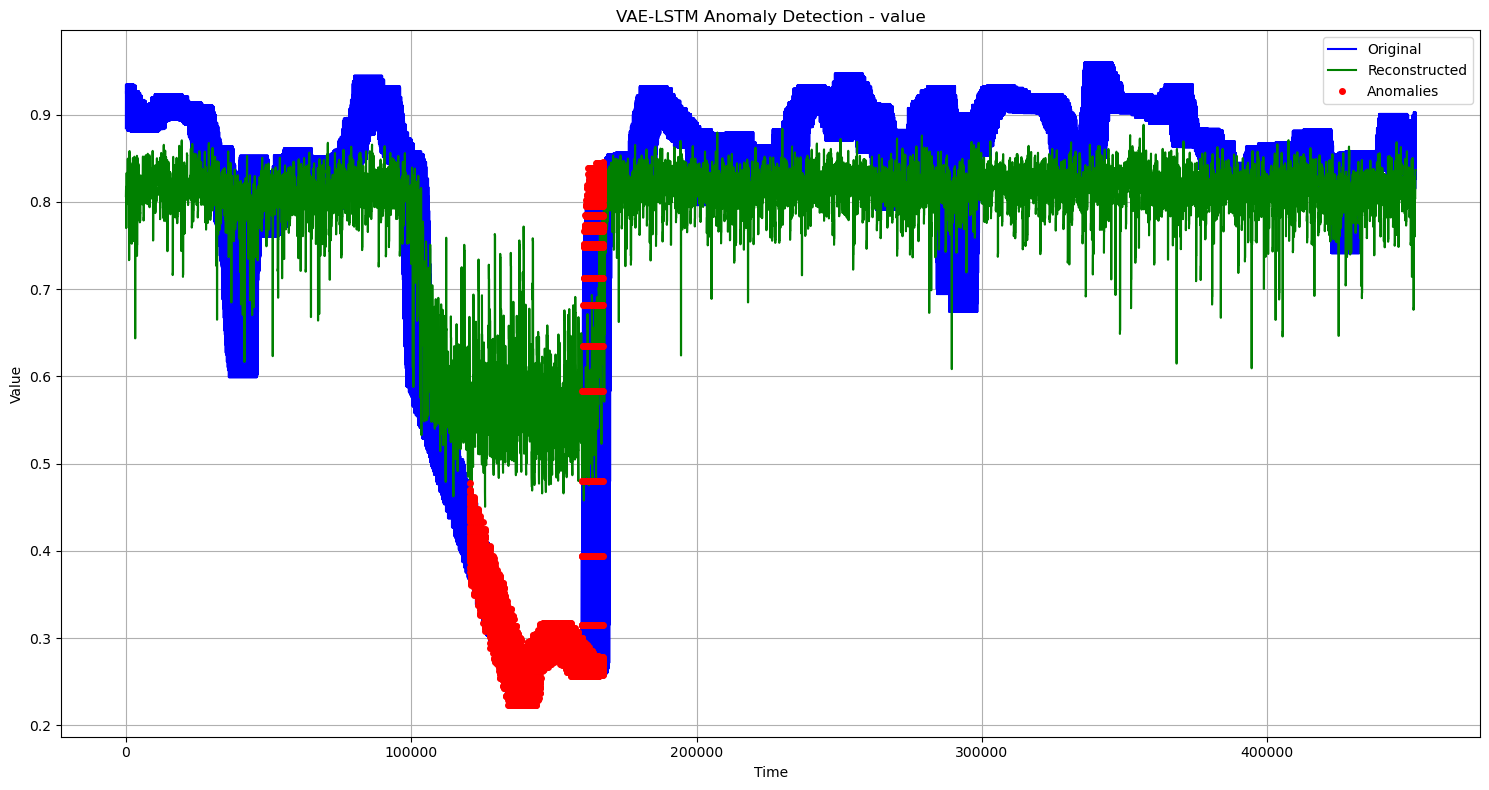

Model saved to outputs/vae_lstm_model.pth
Threshold saved to outputs/threshold.txt
Model config saved to outputs/model_config.txt
Training history saved to outputs/training_history.csv
Training history plot saved to outputs/training_history.png

✅ Training complete!


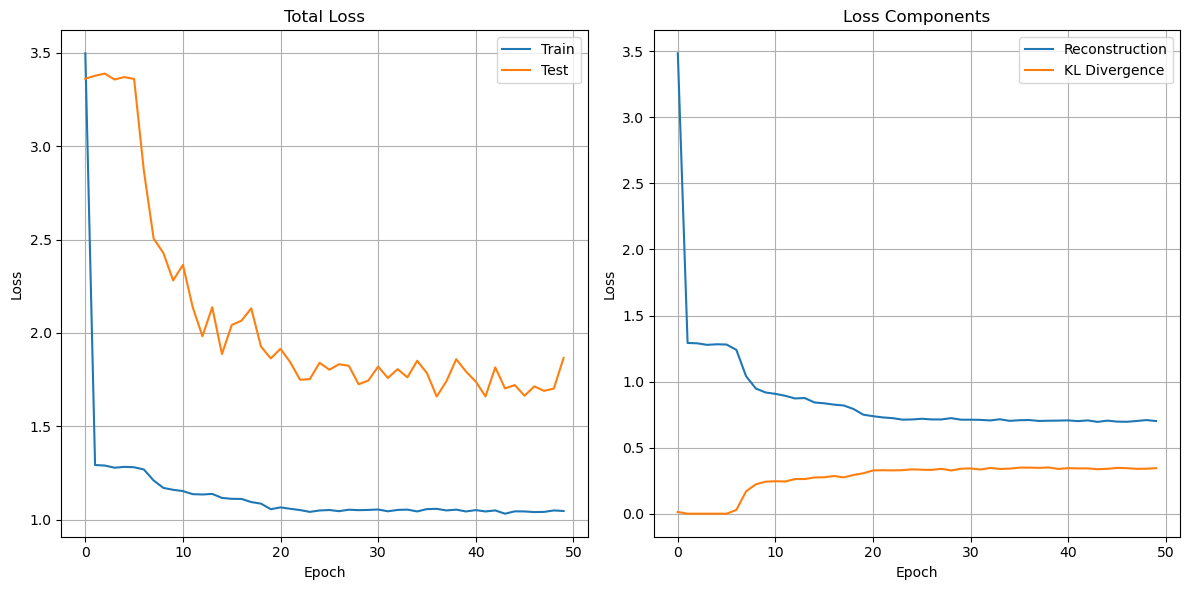

In [4]:
main_train()

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Load saved components (MODIFIED)
def load_saved_model(model_path, config_path):
    """Load model and its configuration"""
    with open(config_path, 'r') as f:
        config = {line.split(':')[0].strip(): int(line.split(':')[1].strip())
                 for line in f.readlines()}

    model = VAE_LSTM(
        input_size=config['input_size'],
        hidden_size=config['hidden_size'],
        latent_dim=config['latent_dim'],
        seq_length=config['seq_length'],
        num_layers=config.get('num_layers', 1)
    )
    model.load_state_dict(torch.load(model_path))
    return model

def load_test_data(data_path, seq_length):
    """Load and preprocess test data from raw CSV"""
    df = pd.read_csv(data_path)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df.values)

    sequences = []
    for i in range(len(data_scaled) - seq_length + 1):
        sequences.append(data_scaled[i:i+seq_length])

    return torch.FloatTensor(np.array(sequences))

# Evaluation functions (FIXED)
def analyze_reconstructions(model, test_data, threshold):
    """Quantitative analysis of reconstructions"""
    model.eval()
    test_loader = DataLoader(TensorDataset(test_data), batch_size=32)

    errors = []
    with torch.no_grad():
        for (batch,) in test_loader:
            _, batch_errors = model.predict(batch)
            errors.append(batch_errors.numpy())

    errors = np.concatenate(errors)

    print("\n=== Reconstruction Error Analysis ===")
    print(f"Threshold (95th percentile): {threshold:.6f}")
    print(f"Mean error: {np.mean(errors):.6f}")
    print(f"Median error: {np.median(errors):.6f}")
    print(f"Max error: {np.max(errors):.6f}")
    print(f"Anomaly rate: {np.mean(errors > threshold)*100:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(errors, bins=50)
    plt.axvline(threshold, color='r', linestyle='--')
    plt.title("Error Distribution")

    plt.subplot(1, 2, 2)
    plt.plot(sorted(errors), 'b-')
    plt.axhline(threshold, color='r', linestyle='--')
    plt.title("Sorted Errors")
    plt.tight_layout()
    plt.show()

# Main evaluation workflow (MODIFIED)
def evaluate_model(output_dir='outputs', data_path='your_data.csv'):
    # Load model components
    model = load_saved_model(
        f"{output_dir}/vae_lstm_model.pth",
        f"{output_dir}/model_config.txt"
    )

    threshold = float(open(f"{output_dir}/threshold.txt").read())
    history = pd.read_csv(f"{output_dir}/training_history.csv")

    # Load test data directly from raw CSV
    seq_length = model.seq_length
    test_data = load_test_data(data_path, seq_length)

    print("=== Model Evaluation ===")
    print(f"Model configuration:")
    print(f"- Sequence length: {seq_length}")
    print(f"- Input features: {model.input_size}")

    # Run evaluations
    analyze_reconstructions(model, test_data, threshold)

# Run the evaluation
if __name__ == "__main__":
    evaluate_model(
        output_dir='../outputs',
        data_path='https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv'  # Replace with your data path
    )

ValueError: could not convert string to float: '2013-12-02 21:15:00'